In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
import math
import re
from pandas.core.frame import DataFrame

**Basic satastic information** 
* Each Data Distribution  
* Monthly trend (Monthly mean & sum)  &  Monthly category sells, Monthly shop sells
* Checking for outliers  
* Missing values? Errors? (filter the Datasets) : one price lower than 0, few higherst price ?

## 1 Load Data

In [3]:
item_cat=pd.read_csv("../datasets/item_categories.csv")
item=pd.read_csv("../datasets/items.csv")
sub=pd.read_csv("../datasets/sample_submission.csv")
shops=pd.read_csv("../datasets/shops.csv")
test=pd.read_csv("../datasets/test.csv")
sales=pd.read_csv("../datasets/sales_train.csv")
monthly_sales = sales.groupby(["date_block_num","shop_id","item_id"])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})
monthly_sales_simple = sales.groupby(["date_block_num"])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})

<ipython-input-3-06772f900ebb>:7: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

<ipython-input-3-06772f900ebb>:9: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



## 2 Data Distribution

### 2.1 Item and Item category

In [4]:
print('number of item category: ', len(item_cat))
print('number of item: ', len(item))

number of item category:  84
number of item:  22170


#### Generating Distribution 
Using data_disribution() to generate each column's distribution  
Using draw_distribution() to generate each file's s(dataset) distributions, and save as ./fig/file_name.jpg

In [3]:
def data_disribution(data, largest=0, label_inform=[''], log = False, dispaly = False):
    ## draw the data distribution
    #  data:  a column list
    #  largest:  only draw top N values. 0 means draw all the data
    #  log:  set_yscale('log')
    distance_dic = {}
    ini = -1
    for i in data:
        if i != ini:
            ini = i
            distance_dic[i] = data.count(i)
            # distance_list.append(i)

    if largest:
        distance_dic_sort = dict(sorted(distance_dic.items(), key=lambda x: x[1], reverse=True)[:largest])
        distance_dic_sort_key = {}
        for key in sorted(distance_dic_sort):
            distance_dic_sort_key[key] = distance_dic_sort[key]

        f_p = plt.gca()
        f_p.bar(range(0, len(distance_dic_sort_key.keys()), 1),distance_dic_sort_key.values(), width=0.7, color='b')        # f_p.set_yscale('log')
        if log:
            f_p.set_yscale('log')
        plt.title(label_inform[0])
        plt.ylabel(label_inform[1])
        plt.xlabel(label_inform[2])
        plt.savefig('../fig/'+label_inform[0]+'.jpg')
        if dispaly:
            plt.show() 
        return

    f_p = plt.gca()
    f_p.bar(range(0, len(distance_dic.keys()), 1),distance_dic.values(), width=0.7, color='b')
    if log:
        f_p.set_yscale('log')
    plt.title(label_inform[0])
    plt.ylabel(label_inform[1])
    plt.xlabel(label_inform[2])
    plt.savefig('../fig/'+label_inform[0]+'.jpg')
    if dispaly:
        plt.show()


def draw_distribution(data, log=False):
    for i in (data.columns.values):
        plot_information = [i, 'frequency', 'counts']
        data_sort = data.sort_values(i)
        data_disribution(list(data_sort[i]),30, plot_information, log = False, dispaly=False)
        print(i, 'save successful')

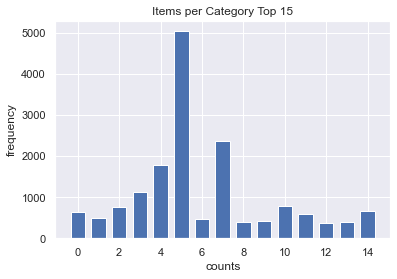

In [7]:
# Items per Category
item_sort = item.sort_values('item_category_id')
plot_information = ['Items per Category Top 15', 'frequency', 'counts']
data_disribution(list(item_sort['item_category_id']),15, plot_information, log = False, dispaly=True)

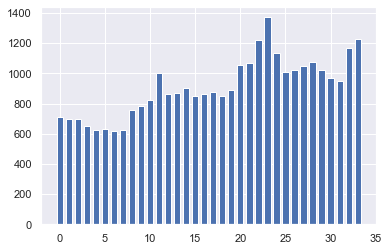

In [30]:
item_sort = monthly_sales_simple.sort_values('item_price')[:30]
f_p = plt.gca()
f_p.bar(range(len(monthly_sales_simple['item_price'])),monthly_sales_simple['item_price'], width=0.7, color='b')
plt.show()

In [8]:
cnt_sort_index = sorted(range(len(sales['item_cnt_day'])), key=lambda k: sales['item_cnt_day'][k], reverse=True)[:100]
price_sort_index = sorted(range(len(sales['item_price'])), key=lambda k: sales['item_price'][k], reverse=True)[:100]

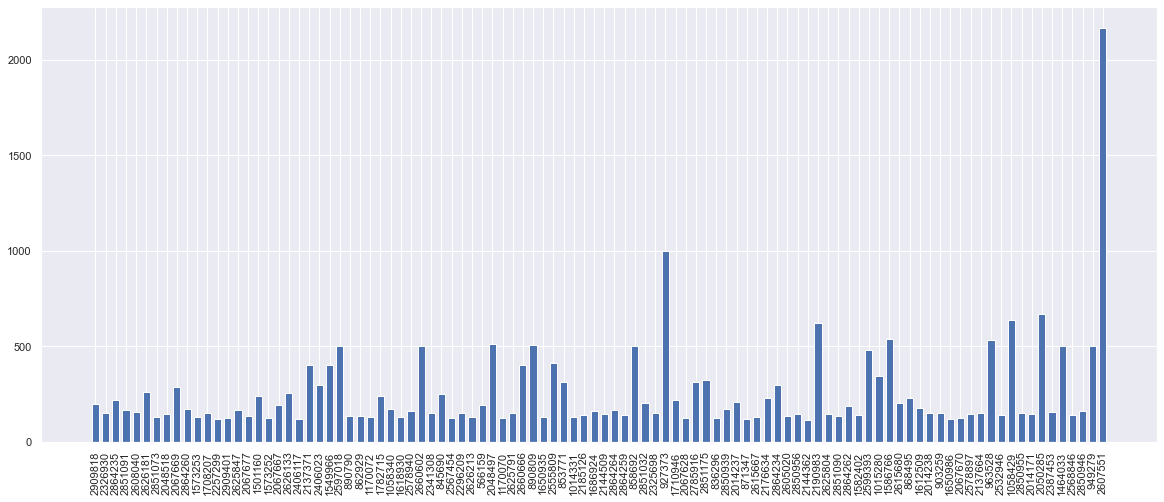

In [40]:
cnt_sort = sales.loc[sorted(cnt_sort_index)]
cnt_shop = sales.loc[cnt_sort_index]['shop_id']
cnt_item = sales.loc[cnt_sort_index]['item_id']
plt.figure(figsize=(20, 8))
f_p = plt.gca()
f_p.bar(range(len(cnt_sort['item_cnt_day'])),cnt_sort['item_cnt_day'], width=0.7, color='b')
plt.xticks(range(len(cnt_sort['item_cnt_day'])), cnt_sort_index, rotation=90)

plt.show()

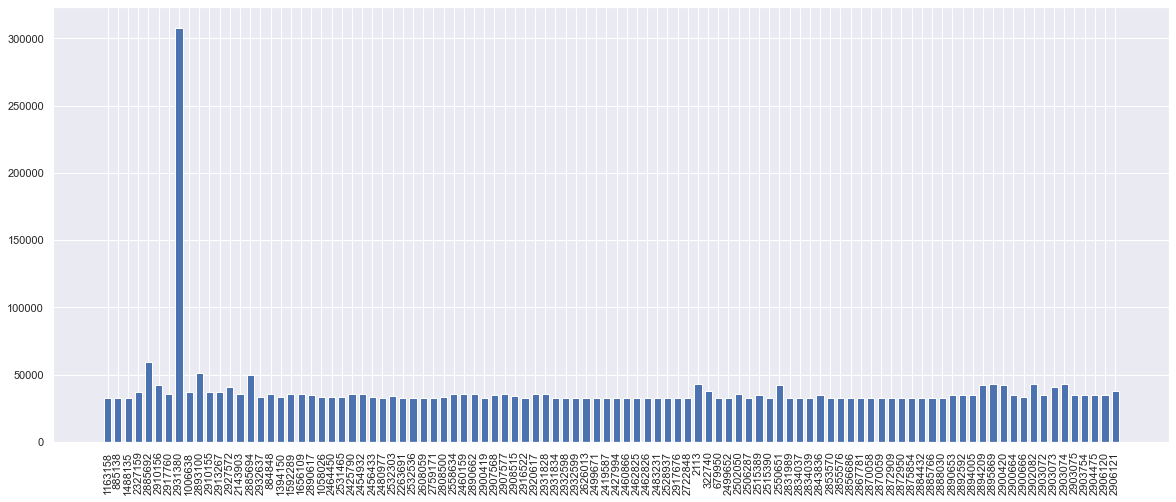

In [127]:
price_sort = sales.loc[sorted(price_sort_index)]
price_item = sales.loc[price_sort_index]['item_id']
price_shop = sales.loc[price_sort_index]['shop_id']
plt.figure(figsize=(20, 8))
f_p = plt.gca()
f_p.bar(range(len(price_sort['item_price'])),price_sort['item_price'], width=0.7, color='b')
plt.xticks(range(len(price_sort['item_price'])), price_sort_index, rotation=90)
plt.show()

We found two unreasonable value  
item_id1 = 11373  index = 2909818  
item_id2 = 6066  index = 1163158

### First outlier, select by cnt_item_day

In [146]:
# Firsy outlier item
sales.loc[2909818]

date              28.10.2015
date_block_num            33
shop_id                   12
item_id                11373
item_price          0.908714
item_cnt_day          2169.0
Name: 2909818, dtype: object

In [90]:
# item name (Delivery to the point of issue (Boxberry))
item[item['item_id'] == 11373]

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


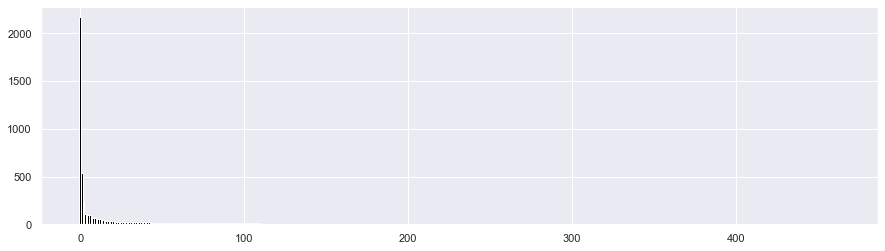

In [94]:
# All item 11373 sales
plt.figure(figsize=(15, 4))
f_p = plt.gca()
# f_p.set_yscale('log')
sort_item_11373 = sorted(sales[sales['item_id'] == 11373]['item_cnt_day'], reverse=True)
f_p.bar(range(len(sales[sales['item_id'] == 11373])), sort_item_11373,  width=1, color='black')
plt.show()

In [87]:
# shop name (E-shop online)
shops[shops['shop_id'] == 12]

,shop_name,shop_id
12,Интернет-магазин ЧС,12


In [88]:
# category name (Delivery of goods)
item_cat[item_cat['item_category_id'] == 9]

,item_category_name,item_category_id
9,Доставка товара,9


In [126]:
# median of item 11373
print('median of item 11373: ', DataFrame(sort_item_11373).median()[0])
# mean of item 11373
print('mean of item 11373: ', DataFrame(sort_item_11373).mean()[0])
# mean of item 11373 without maximum value
print('mean of item 11373 without maximum value: ', DataFrame(sort_item_11373)[1:].mean()[0])

median of item 11373:  4.0
mean of item 11373:  14.144396551724139
mean of item 11373 without maximum value:  9.490280777537796


Then item 11373 on 28.10.2015 could be outlier

we can find it a online shop

### Another outlier, select by item_price

In [144]:
sales.loc[1163158]

date              13.12.2013
date_block_num            11
shop_id                   12
item_id                 6066
item_price          307980.0
item_cnt_day             1.0
Name: 1163158, dtype: object

In [147]:
# item name (kind of VPN)
item[item['item_id'] == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [150]:
# shop name (E-shop online)
shops[shops['shop_id'] == 12]

,shop_name,shop_id
12,Интернет-магазин ЧС,12


In [148]:
# category name (Programs - For home and office)
item_cat[item_cat['item_category_id'] == 75]

,item_category_name,item_category_id
75,Программы - Для дома и офиса,75


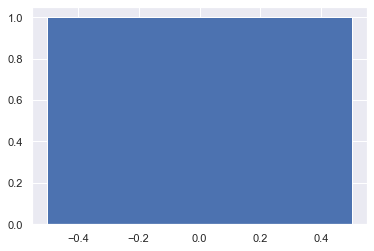

In [156]:
# All item 6066 sales
# plt.figure(figsize=(15, 4))
f_p = plt.gca()
# f_p.set_yscale('log')
sort_item_6066 = sorted(sales[sales['item_id'] == 6066]['item_cnt_day'], reverse=True)
f_p.bar(range(len(sales[sales['item_id'] == 6066])), sort_item_6066,  width=1, color='b')
plt.show()

sold only once, remove is justified

---

## 3 Monthly Trend  
* Price and item_cnt_day

In [5]:
block_cnt_sum = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
block_cnt_mean = sales.groupby(["date_block_num"])["item_cnt_day"].mean()
block_price_sum = sales.groupby(["date_block_num"])["item_price"].sum()
block_price_mean = sales.groupby(["date_block_num"])["item_price"].mean()

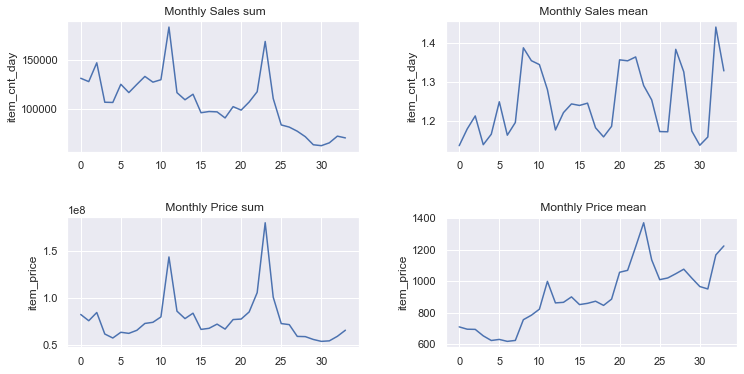

In [6]:
# Monthly sales & price

sns.set(style='darkgrid')
ax=[None for i in range(4)]
fig=plt.figure(figsize=(12,6),facecolor='white')
gs=fig.add_gridspec(2,2)
gs.update(wspace=0.3, hspace=0.5)
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])
ax[2]=fig.add_subplot(gs[1,0])
ax[3]=fig.add_subplot(gs[1,1])
sns.lineplot(x=range(34), y=block_cnt_sum, ax=ax[0]).set_title(" Monthly Sales sum")
sns.lineplot(x=range(34), y=block_cnt_mean, ax=ax[1]).set_title(" Monthly Sales mean")
sns.lineplot(x=range(34), y=block_price_sum, ax=ax[2]).set_title(" Monthly Price sum")
sns.lineplot(x=range(34), y=block_price_mean, ax=ax[3]).set_title(" Monthly Price mean")
plt.show()

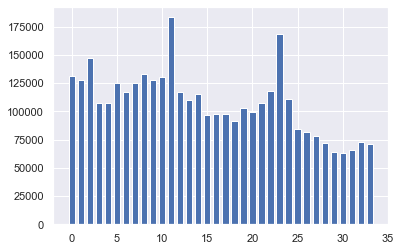

In [26]:
f_p = plt.gca()
f_p.bar(range(len(monthly_sales_simple['item_cnt_day'])),monthly_sales_simple['item_cnt_day'], width=0.7, color='b')
plt.show()

*  Monthly shop turnover, not very clear, waiting optimisation

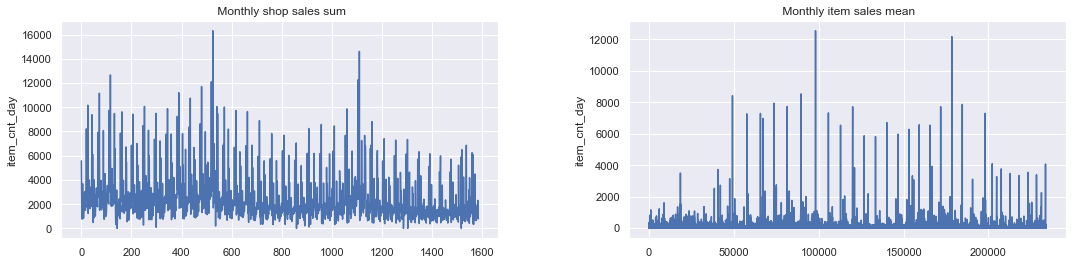

In [472]:

shop_sale = sales.groupby(["date_block_num", "shop_id"])["item_cnt_day"].sum().to_frame()
item_sale = sales.groupby(["date_block_num","item_id"])["item_cnt_day"].sum().to_frame()
item_sale = item_sale[item_sale['item_cnt_day'] < 25000]

sns.set(style='darkgrid')
ax=[None for i in range(2)]
fig=plt.figure(figsize=(18,4),facecolor='white')
gs=fig.add_gridspec(1,2)
gs.update(wspace=0.3, hspace=0.5)
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])
sns.lineplot(x=range(len(shop_sale)), y=shop_sale["item_cnt_day"], ax=ax[0]).set_title(" Monthly shop sales sum")
sns.lineplot(x=range(len(item_sale)), y=item_sale["item_cnt_day"], ax=ax[1]).set_title(" Monthly item sales mean")
plt.show()

<AxesSubplot:xlabel='shop_id'>

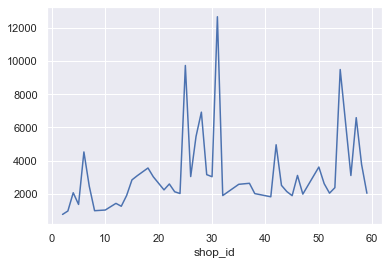

In [460]:
# 03/2013
shop_sale["item_cnt_day"][2].plot()

<AxesSubplot:xlabel='shop_id'>

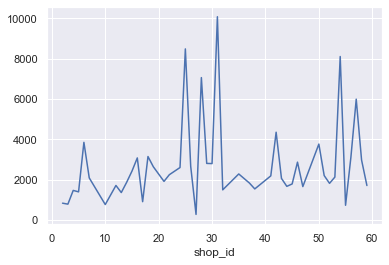

In [454]:
# 06/2013
shop_sale["item_cnt_day"][5].plot()

<AxesSubplot:xlabel='shop_id'>

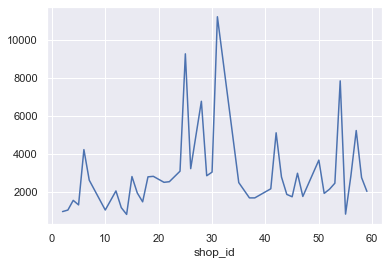

In [456]:
# 09/2013
shop_sale["item_cnt_day"][8].plot()

<AxesSubplot:xlabel='shop_id'>

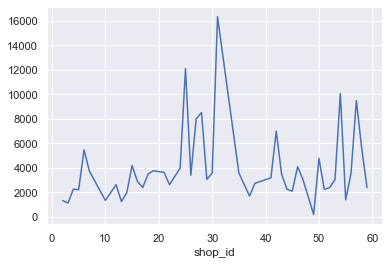

In [455]:
# 12/2013
shop_sale["item_cnt_day"][11].plot()

In [493]:
# Best selling item id and name
item_cat
a2 = item_sale["item_cnt_day"][2]
item_argmax = a2[a2 == a2.max()].index
item[item["item_id"] == item_argmax[0]]

,item_name,item_id,item_category_id
6738,StarCraft II: Heart of the Swarm (дополнение) ...,6738,30


In [471]:
# Best selling shop id and name
shops[shops['shop_id'] == 31]

,shop_name,shop_id
31,"Москва ТЦ ""Семеновский""",31


In [177]:
# def find_season(month):
#     if month == 23:
#         return 3
#     month += 1
#     if month > 12:
#         month = month % 12 

#     season = month / 3
#     # print(season)
#     if season <= 1:
#         return 0
#     if season <= 2:
#         return 1
#     if season <= 3:
#         return 2
#     if season <= 4:
#         return 3

---

## 4 Outliers

Sale volume outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]
Item price outliers: [11365  6066 13199]


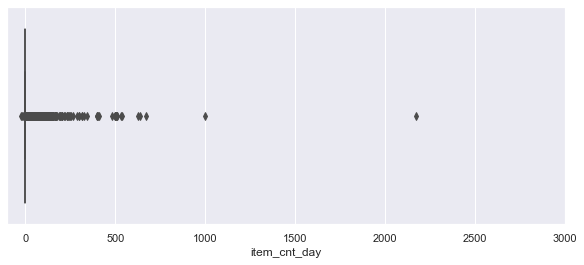

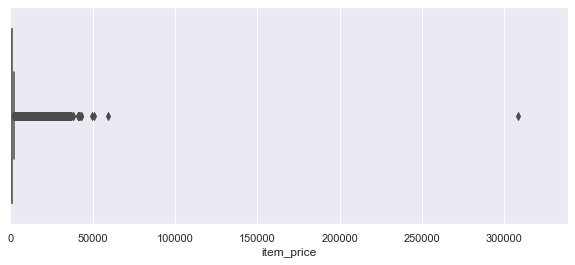

In [501]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales.item_cnt_day)
print('Sale volume outliers:',sales['item_id'][sales['item_cnt_day']>500].unique())

plt.figure(figsize=(10,4))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.1)
sns.boxplot(x=sales.item_price)
print('Item price outliers:',sales['item_id'][sales['item_price']>50000].unique())

### 5 Missing value & Error

#### 5.1 Missing value  
* No missing values found

In [517]:
sales.isnull().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

In [518]:
shops.isnull().any()

shop_name    False
shop_id      False
dtype: bool

In [519]:
item.isnull().any()

item_name           False
item_id             False
item_category_id    False
dtype: bool

In [520]:
item_cat.isnull().any()

item_category_name    False
item_category_id      False
dtype: bool

In [521]:
sub.isnull().any()

ID                False
item_cnt_month    False
dtype: bool

#### 5.2 Error value  (Maybe)
* one price lower than 0  
* few shop_id didn't appear on sales(train) and test set  
* large item_id didn't appear on sales(train) and test set  

In [627]:
sales[sales["item_price"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [573]:
def compare_df(df1, df2, names):
    print('Comparing ', names[2], 'on', names[0], ' and ', names[1])
    df1_list = list(df1[names[2]].drop_duplicates())
    df2_list = list(df2[names[2]].drop_duplicates())
    diff = [y for y in (df1_list + df2_list) if y not in df1_list] # Different
    print('Different:', diff)
    
    only_df1 = [x for x in df1_list if x not in df2_list]  
    only_df2 = [y for y in df2_list if y not in df1_list]  
    print(names[2], ' only occur in', names[0], only_df1)
    print(names[2], ' only occur in', names[1], only_df2)
    print('\n')

In [585]:
# comparing shop_id
compare_df(sales, shops, ["sales", "shops", 'shop_id'])
compare_df(test, shops, ["test", "shops", 'shop_id'])
compare_df(sales, test, ["sales", "test", 'shop_id'])

# comparing item_id (too much)
# compare_df(sales, item, ["sales", "item", 'item_id'])
# compare_df(test, item, ["test", "item", 'item_id'])
# compare_df(sales, test, ["sales", "test", 'item_id'])

Comparing  shop_id on sales  and  shops
Different: []
shop_id  only occur in sales []
shop_id  only occur in shops []


Comparing  shop_id on test  and  shops
Different: [0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]
shop_id  only occur in test []
shop_id  only occur in shops [0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]


Comparing  shop_id on sales  and  test
Different: []
shop_id  only occur in sales [23, 27, 29, 0, 1, 8, 13, 30, 32, 54, 43, 51, 17, 9, 40, 33, 20, 11]
shop_id  only occur in test []




## 6 Correlations

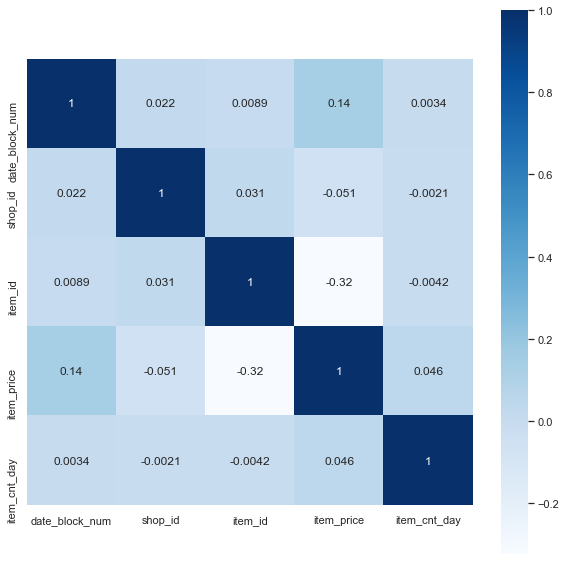

In [614]:
sales_corr_p = sales.corr('spearman')
plt.subplots(figsize=(10,10),facecolor='w')
fig=sns.heatmap(sales_corr_p,annot=True, vmax=1, square=True, cmap="Blues", fmt='.2g')

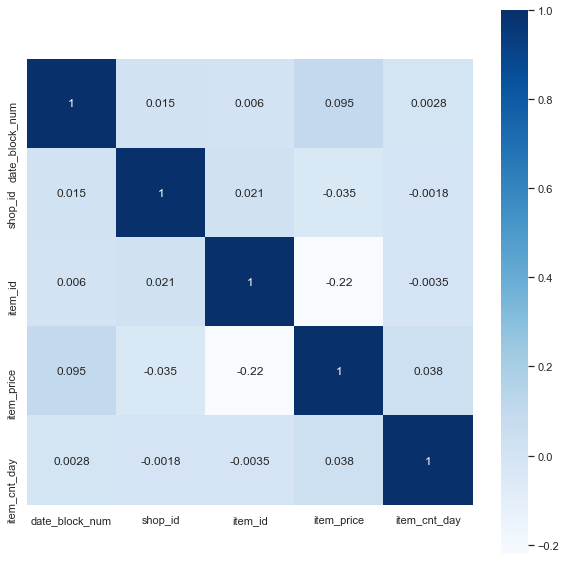

In [615]:
sales_corr_k = sales.corr('kendall')
plt.subplots(figsize=(10,10),facecolor='w')
fig=sns.heatmap(sales_corr_k, annot=True, vmax=1, square=True, cmap="Blues", fmt='.2g')

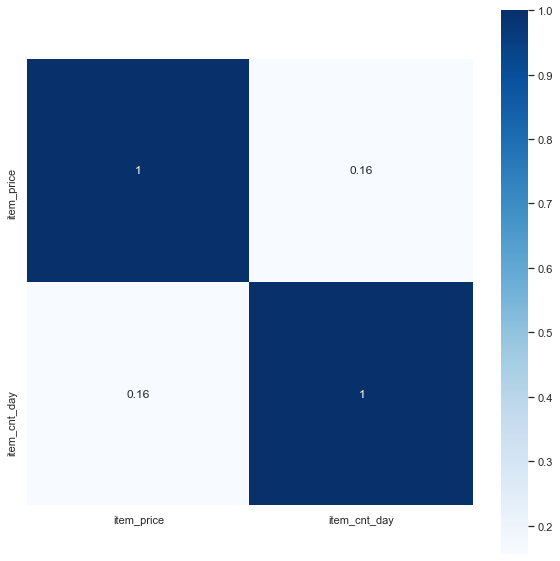

In [616]:
monthly_sales_p = monthly_sales.corr('spearman')
plt.subplots(figsize=(10,10),facecolor='w')
fig=sns.heatmap(monthly_sales_p, annot=True, vmax=1, square=True, cmap="Blues", fmt='.2g')

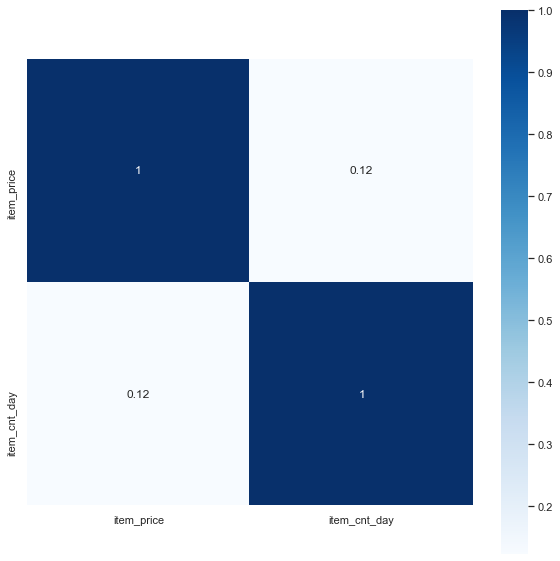

In [617]:
monthly_sales_k = monthly_sales.corr('kendall')
plt.subplots(figsize=(10,10),facecolor='w')
fig=sns.heatmap(monthly_sales_k, annot=True, vmax=1, square=True, cmap="Blues", fmt='.2g')

---

### Data preprocessing

item.csv & item_categories.csv  
* should join to training set (sales)

In [167]:
train = sales.join(item.set_index('item_id'), on='item_id').drop(columns=['item_name'])

In [168]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56
...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,55
2935845,09.10.2015,33,25,7460,299.00,1.0,55
2935846,14.10.2015,33,25,7459,349.00,1.0,55
2935847,22.10.2015,33,25,7440,299.00,1.0,57


shops.csv  
* join the city name

In [169]:
city = DataFrame.copy(shops)
reg = "\s"

for i in range(len(city['shop_name'])):
    shopName = city['shop_name'][i]
    index = re.search(reg, shopName).span()[0]
    city['shop_name'][i] = shopName[:index]
    
city.columns = ["city_name", "shop_id"]
city.loc[city['city_name'] == '!Якутск', 'city_name'] = 'Якутск'
city_id = city['city_name'].drop_duplicates().reset_index(drop=True)
for i in range(len(city_id)):
    city.loc[city['city_name'] == city_id[i], 'city_id'] = int(i)

train = train.join(city.set_index('shop_id'), on='shop_id').drop(columns=['city_name'])

In [170]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_id
0,02.01.2013,0,59,22154,999.00,1.0,37,30.0
1,03.01.2013,0,25,2552,899.00,1.0,58,14.0
2,05.01.2013,0,25,2552,899.00,-1.0,58,14.0
3,06.01.2013,0,25,2554,1709.05,1.0,58,14.0
4,15.01.2013,0,25,2555,1099.00,1.0,56,14.0
...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,55,14.0
2935845,09.10.2015,33,25,7460,299.00,1.0,55,14.0
2935846,14.10.2015,33,25,7459,349.00,1.0,55,14.0
2935847,22.10.2015,33,25,7440,299.00,1.0,57,14.0


drop outlier

In [176]:
train = train[train['item_cnt_day'] < 2000]
train = train[train['item_price'] < 300000]
train = train[train['item_price'] > 0]

In [177]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_id
0,02.01.2013,0,59,22154,999.00,1.0,37,30.0
1,03.01.2013,0,25,2552,899.00,1.0,58,14.0
2,05.01.2013,0,25,2552,899.00,-1.0,58,14.0
3,06.01.2013,0,25,2554,1709.05,1.0,58,14.0
4,15.01.2013,0,25,2555,1099.00,1.0,56,14.0
...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,55,14.0
2935845,09.10.2015,33,25,7460,299.00,1.0,55,14.0
2935846,14.10.2015,33,25,7459,349.00,1.0,55,14.0
2935847,22.10.2015,33,25,7440,299.00,1.0,57,14.0


group by

In [ ]:
train

In [179]:
train.groupby(["date_block_num"])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})

<ipython-input-179-750d9adf72b7>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,item_price,item_cnt_day
date_block_num,,
0,710.622127,131479.0
1,695.866856,128090.0
2,694.688063,147142.0
3,653.633797,107190.0
4,624.186806,106969.0
5,630.893644,125381.0
6,618.578247,116966.0
7,624.576855,125291.0
8,756.228823,133332.0
